<a href="https://colab.research.google.com/github/akshaygrao77/Deep-learning-assignment1/blob/Question-3/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import math

# Only used to show progressbar while inside an epoch
from tqdm.notebook import tqdm 

In [2]:
# !pip install wandb
# !wandb login

In [3]:
# import wandb

# wandb.init(project="Deep learning assignment1", entity="akshaygrao")

In [4]:
# wandb.config = {
#   "learning_rate": 0.001,
#   "epochs": 100,
#   "batch_size": 128
# }

# **Question 1 starts**

Loading dataset from fashio-mnist

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [6]:
def print_image_per_class():
  num_class=10
  for cls in range(num_class):
    i=0
    while(True):
      i=i+1
      if(y_train[i] == cls):
        # image = x_train[i]
        plt.imshow( x_train[i], cmap='gray')
        plt.show()
        plt.close()
        break;

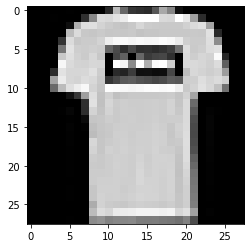

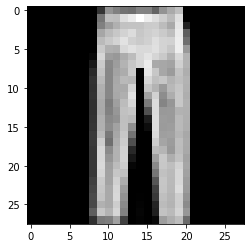

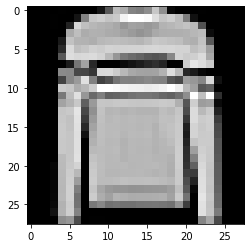

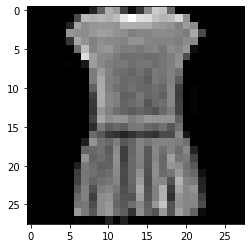

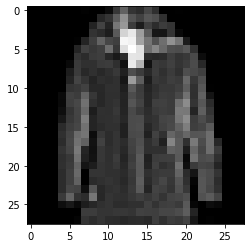

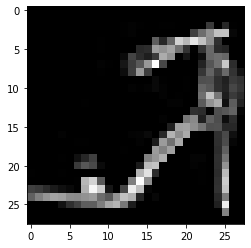

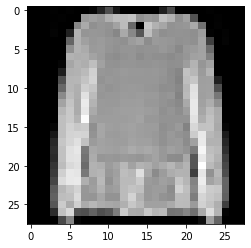

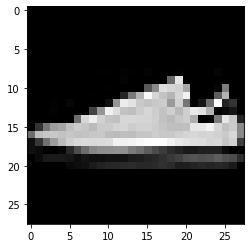

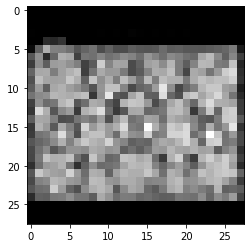

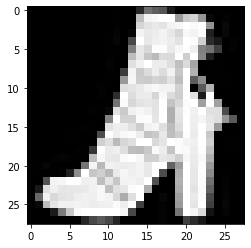

In [7]:
print_image_per_class()

# **Question 2 starts**

In [8]:
x_train.shape

(60000, 28, 28)

In [9]:
x_test.shape

(10000, 28, 28)

Flatten each image into a 1-d array to input to the network

In [45]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

Normalise the array to [0,1] interval

In [44]:
# x_train = x_train / 255
# x_test = x_test / 255

In [12]:
x_train.shape

(60000, 784)

In [13]:
x_test.shape

(10000, 784)

In [14]:
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Categorical encoding for labels

In [15]:
import tensorflow.keras as keras
num_categories = 10

y_train = keras.utils.to_categorical(y_train, num_categories)
y_test = keras.utils.to_categorical(y_test, num_categories)

In [16]:
y_train.shape

(60000, 10)

In [17]:
y_test.shape

(10000, 10)

In [18]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [41]:
class Activation:
    def sigmoid(self, X):
      exp = np.exp(-X)
      if(~(np.isfinite(exp).all())):
        print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
        print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
        print("X",X)
        exp = replaceNanWithMaxAndMin(exp)
      return 1.0 / (1.0 + exp)

    def softmax(self, X):
      exps = np.exp(X)
      if(~(np.isfinite(exps).all())):
        if(np.isnan(exps).any()):
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("X",X)
          print("exps",exps)
        exps = replaceNanWithMaxAndMin(exps)
      
      sum = np.sum(exps)
      if(~(np.isfinite(sum).all())):
        if(np.isnan(sum).any()):
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("sum",sum)
        sum = replaceNanWithMaxAndMin(sum)

      ret = exps / sum
      if(~(np.isfinite(ret).all())):
        if(np.isnan(ret).any()):
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("exps",exps)
          print("sum",sum)
          print("ret",ret)
        ret = replaceNanWithMaxAndMin(ret)

      if(~(np.isfinite(ret).all())):
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
          print("X",X)
          print("np.sum(exps)",np.sum(exps))
          print("exps",exps)
      return ret

In [20]:
  def replaceNanWithMaxAndMin(X):
    if(np.isscalar(X)):
      if(X == float("inf")):
          X = 1e+300
      elif(X == float("-inf")):
          X = 1e-300
      else:
        X = 1e-300
    else:
      if(~(np.isfinite(X).all())):
        nan_indices = np.argwhere(~(np.isfinite(X))).flatten()
        # print("nan_indices",nan_indices)
        for ind in nan_indices:
          # print("Ind",ind)
          # print("X[ind]",X[ind])
          if(X[ind] == float("inf")):
            X[ind] = 1e+300
          elif(X[ind] == float("-inf")):
            X[ind] = 1e-300
          else:
            X[ind] = 1e-300
    return X
      

In [21]:
class InputLayer:
  number_of_inputs=0

  def __init__(self,number_of_inputs) -> None:
      self.number_of_inputs = number_of_inputs

In [22]:
class Layer:
  number_of_neurons=0
  activation = 'sigmoid'
  
  def __init__(self,number_of_neurons,activation) -> None:
      self.number_of_neurons = number_of_neurons
      self.activation = activation

In [23]:
t=[1,2,3]
print(len(t))
for i in range(1,len(t)):
  print(i)

3
1
2


In [24]:
t= np.array([1,2,3])
t= t[np.newaxis]
print(t.T)
print(t.shape)
r = np.array([0,1,2])[np.newaxis].T
r = 5*r
print(r)
print(r.shape)
print(np.matmul(r,t))

[[1]
 [2]
 [3]]
(1, 3)
[[ 0]
 [ 5]
 [10]]
(3, 1)
[[ 0  0  0]
 [ 5 10 15]
 [10 20 30]]


In [25]:
x1 = np.arange(9.0).reshape((3, 3))
print(x1)
x2 = np.arange(3.0).reshape((3,1))
print(x2)
print(np.multiply(x2, x1))
print(np.matmul(x1,x2))

[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
[[0.]
 [1.]
 [2.]]
[[ 0.  0.  0.]
 [ 3.  4.  5.]
 [12. 14. 16.]]
[[ 5.]
 [14.]
 [23.]]


In [26]:
test= [None]*3
test[2]=np.arange(9).reshape((3,3))
print(test)

[None, None, array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])]


In [27]:
a1=np.array([[1,2,3]])
a2 = np.array([2,3,4])
a3 = a1 + a2
print(a3[0])

[3 5 7]


In [60]:
class ANNModel:
  def __init__(self):
    self.layers = []

  def addInputLayer(self,input_layer_obj):
    self.input_layer_obj = input_layer_obj
  
  def addLayer(self,layer_obj):
    self.layers.append(layer_obj)
  
  def compile(self,loss):
    self.loss = loss
    self.randInitWeights()
    self.randInitBiases()
    self.initAH()
    self.array_grad_L_by_A = [None]*(len(self.layers))
    self.array_grad_L_by_weight = [None]*(len(self.layers))
    self.array_grad_L_by_bias = [None]*(len(self.layers))
    self.array_grad_L_by_H = [None]*(len(self.layers))
    
  def initAH(self):
    self.A = []
    for l in range(len(self.layers)):
      self.A.append(np.zeros(self.layers[l].number_of_neurons))
    
    self.H = []
    self.H.append(np.zeros(self.input_layer_obj.number_of_inputs))
    for l in range(1,len(self.layers)+1):
      self.H.append(np.zeros(self.layers[l-1].number_of_neurons))
    
    # print(self.A)
    # print(self.H)

  def randInitWeights(self):
    self.weight_array=[np.random.rand(self.input_layer_obj.number_of_inputs,self.layers[0].number_of_neurons)]
    # print(self.weight_array)
    # print(self.weight_array[0].shape)
    for l in range(1,len(self.layers)):
      self.weight_array.append(np.random.rand(self.layers[l-1].number_of_neurons,self.layers[l].number_of_neurons))
    #   print(self.weight_array[l].shape)
    # print(self.weight_array)
    # print(len(self.weight_array))

  def randInitBiases(self):
    self.bias = []
    for l in range(len(self.layers)):
      self.bias.append(np.random.rand(self.layers[l].number_of_neurons))
      # print(self.bias)
      # print(self.bias[l].shape)

  def predict(self,x_test):
    y_pred = [None]*x_test.shape[0]
    for index in range(x_test.shape[0]):
      y_pred[index] = self.feed_forward(x_test[index])
    y_pred = np.asarray(y_pred)
    return y_pred
  
  def initializeOptimizerStructures(self,optimizer='vanilla'):
    if(optimizer == 'momentum'):
      self.prev_weight_update=[np.zeros((self.input_layer_obj.number_of_inputs,self.layers[0].number_of_neurons))]
      for l in range(1,len(self.layers)):
        self.prev_weight_update.append(np.zeros((self.layers[l-1].number_of_neurons,self.layers[l].number_of_neurons)))
      
      self.prev_bias_update = []
      for l in range(len(self.layers)):
       self.prev_bias_update.append(np.zeros(self.layers[l].number_of_neurons))
  
  # x_valid and y_valid is used only to just check test accuracy during each epoch. It is strictly not part of training
  def train(self,x_train,y_train,epochs,optimizer='vanilla',learning_rate=1,verbose=1,x_valid=None,y_valid=None):
    self.initializeOptimizerStructures(optimizer)
    self.verbose=verbose
    if(self.verbose >= 4):
      self.print_state()
    for current_epoch in range(epochs):
      if(self.verbose >=2):
        print("\n &&&&&&&&&&&&&&&&&&&&  Epoch ",current_epoch," &&&&&&&&&&&&&&&&&&&&&&&&")
      sum_of_loss = 0
      # for index in tqdm(range(50)):
      for index in tqdm(range(x_train.shape[0])):
        if(self.verbose >= 3):
          print("Data point number:",index)
        y_pred = self.feed_forward(x_train[index])
        self.back_prop(y_pred,y_train[index])
        self.updateParameters(optimizer,learning_rate)
        if(self.verbose >= 3):
          print("Predicted output:",y_pred)
          print("Actual output:",y_train[index])
        current_loss = computeLoss(y_pred,y_train[index],self.loss)
        sum_of_loss = sum_of_loss + current_loss
        if(self.verbose >= 4):
          self.print_state()
        if(self.verbose >= 3):
          print("Loss:",current_loss)
      
      if(self.verbose >= 2):
        print("Average ",self.loss, " loss: ",(sum_of_loss/x_train.shape[0]))
        self.showTrainAndTestAccuracyPostTraining(x_train,y_train,x_valid,y_valid)
  
  def showTrainAndTestAccuracyPostTraining(self,x_train,y_train,x_valid,y_valid):
    y_pred_train = self.predict(x_train)
    train_accuracy = calculateClassificationAccuracy(y_pred_train,y_train)
    print("Train accuracy ",train_accuracy)
    if(not(x_valid is None or y_valid is None)):
      y_pred_test = self.predict(x_valid)
      test_accuracy = calculateClassificationAccuracy(y_pred_test,y_valid)
      print("Test accuracy ",test_accuracy)

  def updateParameters(self,optimizer='vanilla',learning_rate=1):
    if(optimizer == 'vanilla'):
      for l in range(len(self.layers)):
        self.weight_array[l] = self.weight_array[l] - (learning_rate)*self.array_grad_L_by_weight[l]
        self.bias[l]=(self.bias[l] - (learning_rate)*self.array_grad_L_by_bias[l])[0]
    elif(optimizer == 'momentum'):
      gamma = 0.9

      for l in range(len(self.layers)):
        self.prev_weight_update[l] = gamma * self.prev_weight_update[l] + (learning_rate)* self.array_grad_L_by_weight[l]
        self.prev_bias_update[l] = (gamma * self.prev_bias_update[l] + (learning_rate)* self.array_grad_L_by_bias[l])[0]  
        self.weight_array[l] = self.weight_array[l] - self.prev_weight_update[l]
        self.bias[l]=self.bias[l] - self.prev_bias_update[l]
    else:
      pass


  def feed_forward(self,inpX):
    self.H[0]= inpX
    for l in range(len(self.layers)):
      self.A[l]=np.matmul(self.H[l],self.weight_array[l]) + self.bias[l]
      self.H[l+1] = calculateActivation(self.layers[l].activation,self.A[l])
    return self.H[len(self.layers)]
  
  def back_prop(self,y_pred,y_train):
    if(self.verbose >= 5):
      print("Back prop starts ===========================")
    self.grad_L_by_ypred = computeLossGradient(y_pred,y_train,self.loss)
    self.grad_ypred_by_Aoutput = computeGradientHwrtA(y_pred,self.A[len(self.layers)-1],self.layers[len(self.layers)-1].activation)
    if(len(self.grad_ypred_by_Aoutput.shape)==2):
      self.array_grad_L_by_A[len(self.layers)-1]=np.matmul(self.grad_L_by_ypred,self.grad_ypred_by_Aoutput)
    else:
      self.array_grad_L_by_A[len(self.layers)-1]=np.multiply(self.grad_L_by_ypred,self.grad_ypred_by_Aoutput)
    
    for l in reversed(range(len(self.layers))):
      current_H=self.H[l]
      current_H=current_H[np.newaxis].T
      if(self.verbose >= 5):
        print("current_H:[",l,"]:",current_H)
        print("current_H shape:[",l,"]:",current_H.shape)
      current_grad_L_by_A = self.array_grad_L_by_A[l]
      if(len(current_grad_L_by_A.shape)==1):
        current_grad_L_by_A = current_grad_L_by_A[np.newaxis]
      
      if(self.verbose >= 5):
        print("current_grad_L_by_A[",l," ]:",current_grad_L_by_A)
        print("current_grad_L_by_A[",l," ] shape:",current_grad_L_by_A.shape)
      
      self.array_grad_L_by_weight[l]=np.matmul(current_H,current_grad_L_by_A)
      
      if(self.verbose >= 5):
        print("self.array_grad_L_by_weight[",l,"]:",self.array_grad_L_by_weight[l])
      
      self.array_grad_L_by_bias[l] = current_grad_L_by_A
      
      if(self.verbose >= 5):
        print("self.array_grad_L_by_bias[",l,"]:",self.array_grad_L_by_bias[l])
      
      self.array_grad_L_by_H[l] = np.matmul(self.weight_array[l],current_grad_L_by_A.T)
      
      if(self.verbose >= 5):
        print("self.array_grad_L_by_H[",l,"]:",self.array_grad_L_by_H[l])
      
      if(l >= 1):
        current_grad_H_by_A = computeGradientHwrtA(self.H[l],self.A[l-1],self.layers[l-1].activation)
        current_grad_H_by_A = current_grad_H_by_A[np.newaxis]
        if(self.verbose >= 5):
          print("current_grad_H_by_A[",l,"]:",current_grad_H_by_A)
        self.array_grad_L_by_A[l-1] = np.multiply(self.array_grad_L_by_H[l].T,current_grad_H_by_A)
        if(self.verbose >= 5):
          print("self.array_grad_L_by_A[",(l-1),"]:",self.array_grad_L_by_A[l-1])



  def print_state(self):
    for l in range(len(self.layers)):
      print("Layer",l)
      print("============================")
      print("Activation:",self.layers[l].activation)
      print("Number of units:",self.layers[l].number_of_neurons)
      print("Weights",self.weight_array[l])
      print("Biases",self.bias[l])
      print("H's",self.H[l])
      print("A's",self.A[l])
      print("**************************")

In [29]:
def calculateClassificationAccuracy(y_pred,y_actual):
  total_samples = y_pred.shape[0]
  correctly_classified_count = 0.0
  for it in range(y_pred.shape[0]):
    classification_index = np.argmax(y_pred[it])
    if(y_actual[it][classification_index]== 1):
      correctly_classified_count= correctly_classified_count + 1
  accuracy = correctly_classified_count/total_samples
  print("Correctly classified:",correctly_classified_count)
  print("total_samples:",total_samples)
  return accuracy

In [39]:
def calculateActivation(activation,A):
  if(activation =='sigmoid'):
    return Activation().sigmoid(A)
  elif(activation == 'softmax'):
    return Activation().softmax(A)
  else:
    print("Invalid activation function")

def computeLoss(y_pred,y_actual,loss):
  loss_value=0
  if(loss=='categorical_crossentropy'):
    # This small epsilon is needed to avoid log(0)=undefined
    epsilon = 1e-300
    # To hold label index from y_actual
    correct_index=findLabelIndex(y_actual)
    if(y_pred[correct_index] != 0):
      loss_value = -math.log(y_pred[correct_index],2)
    else:
      loss_value = -math.log(((y_pred[correct_index])+epsilon),2)
    # loss_value = -np.log2(((y_pred[correct_index])+epsilon))
  return loss_value

def computeLossGradient(y_pred,y_actual,loss):
  grad_L_y = np.zeros(len(y_pred))
  if(loss=='categorical_crossentropy'):
    # This small epsilon is needed to avoid 1/0=inf
    epsilon = 1e-300
    # To hold label index from y_actual
    correct_index=findLabelIndex(y_actual)
    if(y_pred[correct_index] != 0):
      grad_L_y[correct_index] = -1/(y_pred[correct_index])
    else:
      grad_L_y[correct_index] = -1/((y_pred[correct_index])+epsilon)
  
  return grad_L_y

def findLabelIndex(y_actual):
  for j in range(len(y_actual)):
    if(y_actual[j]==1):
      return j

def computeGradientHwrtA(H,A,activation):
  grad_H_by_A = []
  # Gradient is a kxk jacobian
  if(activation == 'softmax'):
    grad_H_by_A=computeSoftmaxGrad(H)
  elif(activation == 'sigmoid'):
    grad_H_by_A=computeSigmoidGrad(H)
  return grad_H_by_A

def computeSoftmaxGrad(H):
  grad_softmax_jacobian = np.zeros(H.shape[0]*H.shape[0]).reshape(H.shape[0],H.shape[0])
  for i in range(H.shape[0]):
    for j in range(H.shape[0]):
      if(i == j):
        grad_softmax_jacobian[i][j] = H[i]*(1-H[j])
      else:
        grad_softmax_jacobian[i][j] = -H[i]*H[j]
  return grad_softmax_jacobian

  
def computeSigmoidGrad(H):
  return H*(1-H)

In [31]:
sample_xtrain=np.array([[1,2],[2,3],[3,4]])
sample_xtrain=sample_xtrain.astype('uint8')
print(sample_xtrain.shape)
print(sample_xtrain[0])

(3, 2)
[1 2]


In [32]:
sample_xtrain[0]

array([1, 2], dtype=uint8)

In [33]:
sample_ytrain=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
sample_ytrain=sample_ytrain.astype('float32')
print(sample_ytrain)
print(sample_ytrain.shape)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
(3, 4)


In [34]:
sample_ytrain[0]

array([1., 0., 0., 0.], dtype=float32)

In [62]:
def runToyTest():
  ann_model = ANNModel()
  input_layer = InputLayer(2)
  hidden_layer1 = Layer(5,activation='sigmoid')
  hidden_layer2 = Layer(10,activation='sigmoid')
  output_layer = Layer(4,activation='softmax')

  ann_model.addInputLayer(input_layer)
  ann_model.addLayer(hidden_layer1)
  # ann_model.addLayer(hidden_layer2)
  ann_model.addLayer(output_layer)

  ann_model.compile('categorical_crossentropy')
  ann_model.train(sample_xtrain,sample_ytrain,1,'momentum',1,4)
  # ann_model.print_state()
  y_pred_test = ann_model.predict(sample_xtrain)
  print(y_pred_test)
  test_accuracy = calculateClassificationAccuracy(y_pred_test,sample_ytrain)
  print("Test Accuracy:",test_accuracy)

In [63]:
runToyTest()

Layer 0
Activation: sigmoid
Number of units: 5
Weights [[0.85311647 0.82161358 0.82660646 0.5852121  0.90103609]
 [0.14684597 0.63225605 0.56297652 0.63205827 0.76068875]]
Biases [0.69986321 0.66219828 0.50409736 0.56872713 0.97306205]
H's [0. 0.]
A's [0. 0. 0. 0. 0.]
**************************
Layer 1
Activation: softmax
Number of units: 4
Weights [[0.47741001 0.87876822 0.54793059 0.03037661]
 [0.67796872 0.26815731 0.769076   0.36248986]
 [0.74798904 0.24609583 0.67439233 0.8555373 ]
 [0.82049154 0.73228967 0.02551581 0.84266371]
 [0.61274425 0.15642795 0.08375322 0.64358535]]
Biases [0.11877974 0.82909059 0.11520044 0.34647434]
H's [0. 0. 0. 0. 0.]
A's [0. 0. 0. 0.]
**************************

 &&&&&&&&&&&&&&&&&&&&  Epoch  0  &&&&&&&&&&&&&&&&&&&&&&&&


  0%|          | 0/3 [00:00<?, ?it/s]

Data point number: 0
Predicted output: [0.35979583 0.26311688 0.11204863 0.26503866]
Actual output: [1. 0. 0. 0.]
Layer 0
Activation: sigmoid
Number of units: 5
Weights [[0.85370204 0.8318641  0.83473639 0.59320474 0.90640805]
 [0.14801712 0.65275708 0.57923639 0.64804355 0.77143266]]
Biases [0.70044878 0.67244879 0.5122273  0.57671977 0.978434  ]
H's [1 2]
A's [1.84667163 2.74832396 2.45665686 2.41805578 3.39547565]
**************************
Layer 1
Activation: softmax
Number of units: 4
Weights [[ 1.0303773   0.65150474  0.45115017 -0.19854678]
 [ 1.27964453  0.02087516  0.66377061  0.11340159]
 [ 1.3376471   0.00375284  0.57119028  0.61142427]
 [ 1.40832306  0.49069737 -0.07736655  0.59930685]
 [ 1.23218202 -0.09815417 -0.02466088  0.38714379]]
Biases [0.75898391 0.56597371 0.0031518  0.08143568]
H's [0.86373584 0.93981862 0.92104689 0.91819383 0.96756284]
A's [3.20347532 2.89053695 2.03687159 2.89781429]
**************************
Loss: 1.4747496411415233
Data point number: 1
Pred

In [55]:
np.seterr(all='warn')
ann_model = ANNModel()
input_layer = InputLayer(x_train.shape[1])
hidden_layer1 = Layer(132,activation='sigmoid')
hidden_layer2 = Layer(132,activation='sigmoid')
hidden_layer3 = Layer(32,activation='sigmoid')
output_layer = Layer(10,activation='softmax')

ann_model.addInputLayer(input_layer)
ann_model.addLayer(hidden_layer1)
# ann_model.addLayer(hidden_layer2)
# ann_model.addLayer(hidden_layer3)
ann_model.addLayer(output_layer)

ann_model.compile('categorical_crossentropy')
ann_model.train(x_train,y_train,1,"momentum",0.01,4,x_test,y_test)
# ann_model.print_state()
y_pred_test = ann_model.predict(x_test)
test_accuracy = calculateClassificationAccuracy(y_pred_test,y_test)

Layer 0
Activation: sigmoid
Number of units: 132
Weights [[0.44231241 0.44252722 0.90927278 ... 0.16281283 0.43742713 0.38232994]
 [0.31702741 0.23675084 0.12195354 ... 0.59159075 0.20989089 0.57478315]
 [0.1979442  0.65180664 0.21396817 ... 0.58841573 0.45549998 0.36862271]
 ...
 [0.9409683  0.33770004 0.53346575 ... 0.56939149 0.59123022 0.08869334]
 [0.61311975 0.10386746 0.27983258 ... 0.23851937 0.5628093  0.77971069]
 [0.4113466  0.0394875  0.54438539 ... 0.98957179 0.56517552 0.68889505]]
Biases [1.83429173e-01 3.11240874e-01 4.63890808e-01 2.55053981e-01
 6.21515690e-01 3.82945652e-01 2.84618339e-01 9.00476721e-01
 1.50084857e-01 3.51768030e-01 8.90139631e-01 9.13151480e-01
 8.75383893e-01 8.10827810e-03 8.70438466e-01 6.91472798e-01
 2.33280036e-01 9.04213578e-01 1.32709873e-01 8.34670962e-01
 9.97397770e-01 7.71640701e-01 2.31908271e-01 4.28948646e-01
 1.46269151e-01 7.30046176e-01 8.97839174e-01 8.81175034e-01
 7.76322461e-01 4.13282920e-01 3.79027062e-01 8.94997533e-01
 6.5

  0%|          | 0/50 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
 0.         0.         0.         0.         0.         0.
 0.24313725 0.5254902  0.65882353 0.65490196 0.24313725 0.39607843
 0.36470588 0.4        0.38431373 0.54901961 0.55686275 0.38823529
 0.40392157 0.32941176 0.36862745 0.23137255 0.57254902 0.75686275
 0.47058824 0.25098039 0.         0.         0.         0.
 0.         0.         0.         0.         0.23921569 0.47058824
 0.69411765 0.44705882 0.48627451 0.61960784 0.62745098 0.65490196
 0.45490196 0.58823529 0.54901961 0.47843137 0.65882353 0.65882353
 0.63529412 0.50980392 0.46666667 0.76470588 0.4745098  0.27058824
 0.         0.         0.         0.         0.         0.
 0.         0.         0.2        0.47843137 0.70980392 0.17254902
 0.69019608 0.76470588 0.72156863 0.68627451 0.36078431 0.46666667
 0.42352941 0.45882353 0.73333333 0.70980392 0.76078431 0.74901961
 0.19215686 0.7254902  0.47058824 0.2627451  0.         0.
 0.         0.         0.         0.       

In [101]:
np.finfo(np.float64).max

1.7976931348623157e+308

In [75]:
np.log2(2)

1.0